In [5]:
import importlib
import sys
import torch
import pickle
import os

sys.path.insert(0, '..')
sys.path.insert(0, '../..')
sys.path.insert(0, '../../..')
sys.path.insert(0, '../../../..')

from model.dropout_uncertainty_enc_dec_LSTM.dropout_uncertainty_model import DropoutUncertaintyEncoderDecoderLSTM

In [6]:
#load model
file_path_model = '../../../training_variational_dropout/Helpdesk/Helpdesk_full_grad_norm_new_4layer.pkl'
model = DropoutUncertaintyEncoderDecoderLSTM.load(file_path_model, dropout=0.1)

# Load the dataset
file_path_data_set = '../../../../../encoded_data/test_weytjens//helpdesk_all_5_test.pkl'
helpdesk_test_dataset = torch.load(file_path_data_set, weights_only=False)

Data set categories:  ([('Activity', 16, {'Assign seriousness': 1, 'Closed': 2, 'Create SW anomaly': 3, 'DUPLICATE': 4, 'EOS': 5, 'INVALID': 6, 'Insert ticket': 7, 'RESOLVED': 8, 'Require upgrade': 9, 'Resolve SW anomaly': 10, 'Resolve ticket': 11, 'Schedule intervention': 12, 'Take in charge ticket': 13, 'VERIFIED': 14, 'Wait': 15}), ('Resource', 24, {'EOS': 1, 'Value 1': 2, 'Value 10': 3, 'Value 11': 4, 'Value 12': 5, 'Value 13': 6, 'Value 14': 7, 'Value 15': 8, 'Value 16': 9, 'Value 17': 10, 'Value 18': 11, 'Value 19': 12, 'Value 2': 13, 'Value 20': 14, 'Value 21': 15, 'Value 22': 16, 'Value 3': 17, 'Value 4': 18, 'Value 5': 19, 'Value 6': 20, 'Value 7': 21, 'Value 8': 22, 'Value 9': 23}), ('VariantIndex', 175, {'1.0': 1, '10.0': 2, '100.0': 3, '103.0': 4, '104.0': 5, '107.0': 6, '109.0': 7, '11.0': 8, '110.0': 9, '112.0': 10, '113.0': 11, '114.0': 12, '115.0': 13, '117.0': 14, '118.0': 15, '12.0': 16, '120.0': 17, '122.0': 18, '123.0': 19, '124.0': 20, '125.0': 21, '126.0': 22, '12

In [7]:
import evaluation.probabilistic_evaluation
importlib.reload(evaluation.probabilistic_evaluation)
from evaluation.probabilistic_evaluation import ProbabilisticEvaluation

new_eval = ProbabilisticEvaluation(model=model, 
                                   dataset=helpdesk_test_dataset,
                                   concept_name='Activity',
                                   num_processes=16,
                                   #growing_num_values = [],
                                   growing_num_values = ['case_elapsed_time'],
                                   samples_per_case = 10,
                                   sample_argmax = False,
                                   use_variance_cat = True,
                                   use_variance_num = True,
                                   all_cat=['Activity', 'Resource'],
                                   all_num=['case_elapsed_time', 'event_elapsed_time'])

  0%|          | 0/916 [00:00<?, ?it/s]

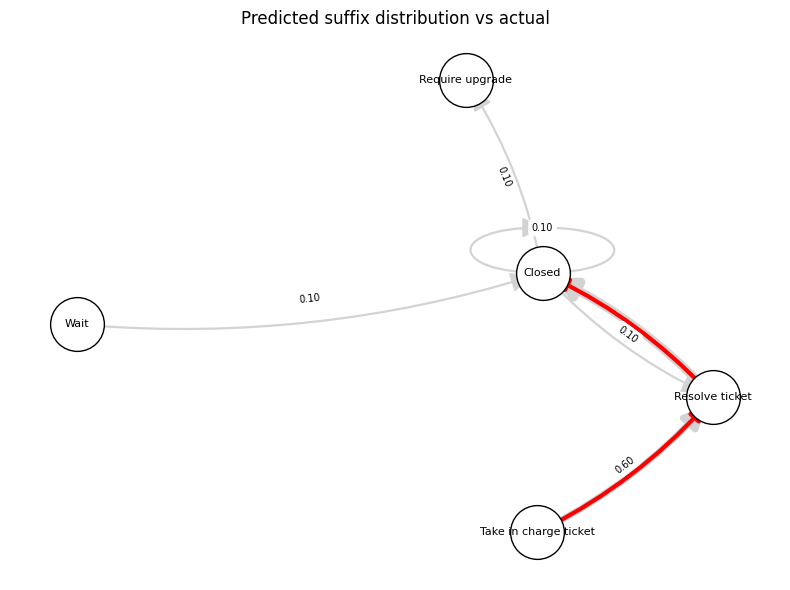

1 3


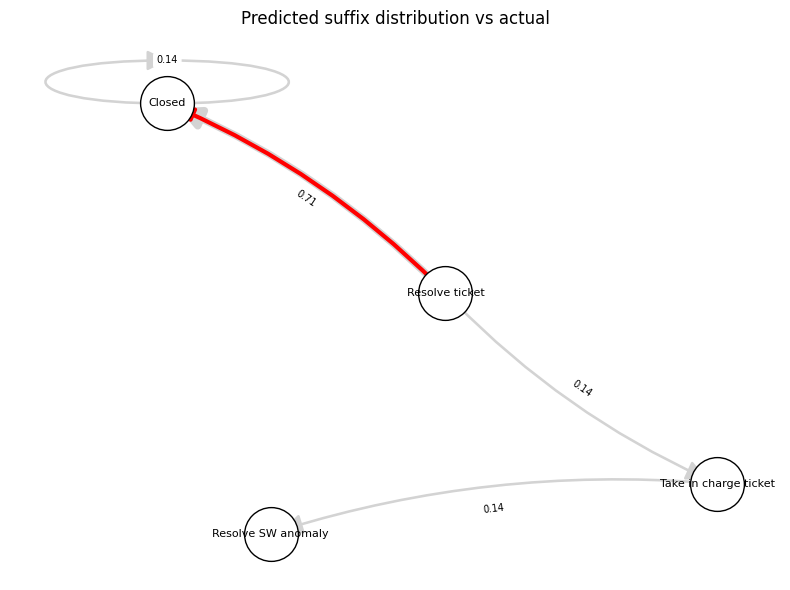

2 2


ValueError: No non-empty traces with edges were provided.

In [8]:
from visualization.suffix_visualizer import SuffixDFGVisualizer
import matplotlib.pyplot as plt 

def save_chunk(results, i):
    chunk_number = (i + 1)
    filename = os.path.join(output_dir, f'results_part_{chunk_number:03d}.pkl')
    with open(filename, 'wb') as f:
        pickle.dump(results, f)
    print(f"Saved {len(results)} results to {filename}")

output_dir = '../../../../../../../evaluation_results/Helpdesk'

save_every = 10

results = {}
for i, (case_name, prefix_len, prefix, predicted_suffixes, suffix, mean_prediction) in enumerate(new_eval.evaluate(random_order=True)):
    fig = SuffixDFGVisualizer.visualize(
        predicted_suffixes=predicted_suffixes,
        correct_suffix=suffix,
        ignore_activities={"EOS"},
        min_prob=0.00,
        layout="spring",
        title="Predicted suffix distribution vs actual"
    )
    plt.show()
    assert((case_name, prefix_len) not in results)
    results[(case_name, prefix_len)] = (prefix, suffix, mean_prediction, predicted_suffixes)
    print(prefix_len, len(suffix))
    if (i + 1) % save_every == 0:
        save_chunk(results, i)
        results = {}

if len(results):
    save_chunk(results, i)